# Strategie di Blocking per Entity Resolution

## Obiettivo 4.D
Definire e valutare **due strategie di blocking** (B1 e B2) per ridurre lo spazio di ricerca nel matching.

### Problema:
Il confronto **naïve** di tutti i record richiederebbe:
- Prodotto cartesiano: `|Dataset A| × |Dataset B|` confronti
- Computazionalmente **intrattabile** per dataset grandi

### Soluzione: Blocking
Partizionare i dataset in **blocchi** usando una **blocking key**:
- Solo record nello stesso blocco vengono confrontati
- Riduzione drastica delle coppie candidate

### Strategie Implementate:

**B1: Manufacturer + Model**
- Blocking key: `manufacturer_model`
- Più permissivo (cattura match anche con errori nell'anno)
- Trade-off: Blocchi più grandi, maggiore recall

**B2: Manufacturer + Model + Year**
- Blocking key: `manufacturer_model_year`
- Più restrittivo (blocchi più piccoli, più efficiente)
- Trade-off: Maggiore precision, rischio di perdere match con errori nell'anno

### Metriche di Valutazione:

1. **Pairs Completeness (PC)**: % di veri match (GT positivi) catturati dalle coppie candidate
   - `PC = TP_found / Total_GT_Positives`
   - Misura: Quanti veri match NON perdiamo?

2. **Pairs Quality (PQ)**: % di coppie candidate che sono veri match
   - `PQ = TP_found / Total_Candidate_Pairs`
   - Misura: Quanto è "pulito" il risultato del blocking?

3. **Reduction Ratio (RR)**: % di confronti evitati rispetto al prodotto cartesiano
   - `RR = 1 - (Candidate_Pairs / Cartesian_Product)`
   - Misura: Quanta efficienza abbiamo guadagnato?

4. **F1-Score**: Media armonica di PC e PQ
   - `F1 = 2 × (PC × PQ) / (PC + PQ)`
   - Misura: Bilanciamento recall/precision

## 1. Import Librerie

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict
import json

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("✅ Librerie importate con successo!")

✅ Librerie importate con successo!


## 2. Caricamento Dataset NO-VIN e Ground-Truth

In [19]:
print("CARICAMENTO DATASET")
print("="*100)

# Carica dataset NO-VIN (già creati nella fase di ground-truth)
print("\n📁 Dataset NO-VIN (senza colonna VIN):")
df_A = pd.read_csv('ground_truth/dataset_A_no_vin.csv')
df_B = pd.read_csv('ground_truth/dataset_B_no_vin.csv')

print(f"  Dataset A (Craigslist): {len(df_A):,} righe × {len(df_A.columns)} colonne")
print(f"  Dataset B (Used Cars): {len(df_B):,} righe × {len(df_B.columns)} colonne")

# Carica ground-truth completo (positivi + negativi con label)
print("\n📁 Ground-Truth:")
df_ground_truth = pd.read_csv('ground_truth/ground_truth_complete.csv')

print(f"  Ground-Truth Completo: {len(df_ground_truth):,} coppie")
print(f"    - Positive (label=1): {(df_ground_truth['label']==1).sum():,}")
print(f"    - Negative (label=0): {(df_ground_truth['label']==0).sum():,}")

# Estrai solo i positivi per valutazione blocking
df_gt_positive = df_ground_truth[df_ground_truth['label'] == 1].copy()
print(f"\n  ℹ️  Useremo {len(df_gt_positive):,} coppie POSITIVE per valutare il blocking")
print(f"     (Vogliamo verificare quante di queste vengono catturate da B1 e B2)")

# Calcola prodotto cartesiano teorico
cartesian_product = len(df_A) * len(df_B)
print(f"\n⚠️  Prodotto cartesiano totale: {cartesian_product:,} confronti")
print(f"   (Questo è il numero di confronti SENZA blocking)")

CARICAMENTO DATASET

📁 Dataset NO-VIN (senza colonna VIN):
  Dataset A (Craigslist): 14,492 righe × 19 colonne
  Dataset B (Used Cars): 15,375 righe × 19 colonne

📁 Ground-Truth:
  Ground-Truth Completo: 15,412 coppie
    - Positive (label=1): 3,853
    - Negative (label=0): 11,559

  ℹ️  Useremo 3,853 coppie POSITIVE per valutare il blocking
     (Vogliamo verificare quante di queste vengono catturate da B1 e B2)

⚠️  Prodotto cartesiano totale: 222,814,500 confronti
   (Questo è il numero di confronti SENZA blocking)


In [20]:
# Verifica schema dataset
print("\nVERIFICA SCHEMA DATASET")
print("="*100)

print("\nColonne Dataset A:")
print(list(df_A.columns))

print("\nColonne Dataset B:")
print(list(df_B.columns))

print("\nColonne Ground-Truth:")
print(list(df_ground_truth.columns))

# Verifica presenza colonne necessarie per blocking
required_cols_A = ['vehicle_id', 'manufacturer', 'model', 'year']
required_cols_B = ['vehicle_id', 'manufacturer', 'model', 'year']

missing_A = [col for col in required_cols_A if col not in df_A.columns]
missing_B = [col for col in required_cols_B if col not in df_B.columns]

if missing_A:
    print(f"\n❌ ATTENZIONE: Colonne mancanti in Dataset A: {missing_A}")
else:
    print(f"\n✅ Dataset A ha tutte le colonne necessarie per blocking")

if missing_B:
    print(f"❌ ATTENZIONE: Colonne mancanti in Dataset B: {missing_B}")
else:
    print(f"✅ Dataset B ha tutte le colonne necessarie per blocking")


VERIFICA SCHEMA DATASET

Colonne Dataset A:
['body_type', 'cylinders', 'description', 'drive_type', 'exterior_color', 'fuel_type', 'image_url', 'latitude', 'listing_date', 'location', 'longitude', 'manufacturer', 'mileage', 'model', 'price', 'source_dataset', 'transmission', 'vehicle_id', 'year']

Colonne Dataset B:
['body_type', 'cylinders', 'description', 'drive_type', 'exterior_color', 'fuel_type', 'image_url', 'latitude', 'listing_date', 'location', 'longitude', 'manufacturer', 'mileage', 'model', 'price', 'source_dataset', 'transmission', 'vehicle_id', 'year']

Colonne Ground-Truth:
['vin', 'craigslist_id', 'used_cars_id', 'year', 'manufacturer_cr', 'manufacturer_uc', 'model_cr', 'model_uc', 'price_cr', 'price_uc', 'mileage_cr', 'mileage_uc', 'warnings', 'warning_details', 'label']

✅ Dataset A ha tutte le colonne necessarie per blocking
✅ Dataset B ha tutte le colonne necessarie per blocking


## 3. Funzioni per Blocking

In [21]:
def normalize_string(s):
    """
    Normalizza una stringa per blocking:
    - Lowercase
    - Rimuovi spazi extra
    - Gestisci valori mancanti
    """
    if pd.isna(s):
        return "UNKNOWN"
    return str(s).lower().strip().replace('  ', ' ')

def create_blocking_key_B1(row):
    """
    B1: Manufacturer + Model
    
    Crea chiave di blocking concatenando manufacturer e model normalizzati.
    """
    manufacturer = normalize_string(row.get('manufacturer', ''))
    model = normalize_string(row.get('model', ''))
    return f"{manufacturer}||{model}"

def create_blocking_key_B2(row):
    """
    B2: Manufacturer + Model + Year
    
    Crea chiave di blocking concatenando manufacturer, model e year normalizzati.
    """
    manufacturer = normalize_string(row.get('manufacturer', ''))
    model = normalize_string(row.get('model', ''))
    year = str(int(row['year'])) if pd.notna(row.get('year')) else "UNKNOWN"
    return f"{manufacturer}||{model}||{year}"

print("✅ Funzioni di blocking definite")
print("\nTest normalizzazione:")
test_strings = ['  Ford  ', 'TOYOTA', 'Chevrolet', None, 'BMW  M3']
for s in test_strings:
    print(f"  '{s}' → '{normalize_string(s)}'")

print("\nTest creazione blocking key:")
test_row = {'manufacturer': 'Ford', 'model': 'F-150', 'year': 2015}
print(f"  Row: {test_row}")
print(f"  B1: '{create_blocking_key_B1(test_row)}'")
print(f"  B2: '{create_blocking_key_B2(test_row)}'")

✅ Funzioni di blocking definite

Test normalizzazione:
  '  Ford  ' → 'ford'
  'TOYOTA' → 'toyota'
  'Chevrolet' → 'chevrolet'
  'None' → 'UNKNOWN'
  'BMW  M3' → 'bmw m3'

Test creazione blocking key:
  Row: {'manufacturer': 'Ford', 'model': 'F-150', 'year': 2015}
  B1: 'ford||f-150'
  B2: 'ford||f-150||2015'


## 4. Applicazione Blocking ai Dataset

In [22]:
print("APPLICAZIONE BLOCKING AI DATASET")
print("="*100)

# ========== STRATEGIA B1: Manufacturer + Model ==========
print("\n🔹 STRATEGIA B1: Manufacturer + Model")
print("-"*100)

df_A['blocking_key_B1'] = df_A.apply(create_blocking_key_B1, axis=1)
df_B['blocking_key_B1'] = df_B.apply(create_blocking_key_B1, axis=1)

# Statistiche B1
blocks_A_B1 = df_A['blocking_key_B1'].value_counts()
blocks_B_B1 = df_B['blocking_key_B1'].value_counts()
common_blocks_B1 = set(blocks_A_B1.index).intersection(set(blocks_B_B1.index))

print(f"Blocchi unici in Dataset A: {len(blocks_A_B1):,}")
print(f"Blocchi unici in Dataset B: {len(blocks_B_B1):,}")
print(f"Blocchi comuni (con potenziali match): {len(common_blocks_B1):,}")
print(f"\nDimensione media blocchi:")
print(f"  Dataset A: {blocks_A_B1.mean():.1f} record/blocco")
print(f"  Dataset B: {blocks_B_B1.mean():.1f} record/blocco")
print(f"\nTop 5 blocchi più grandi (Dataset A):")
for key, count in blocks_A_B1.head().items():
    print(f"  {key}: {count} record")

# ========== STRATEGIA B2: Manufacturer + Model + Year ==========
print("\n🔹 STRATEGIA B2: Manufacturer + Model + Year")
print("-"*100)

df_A['blocking_key_B2'] = df_A.apply(create_blocking_key_B2, axis=1)
df_B['blocking_key_B2'] = df_B.apply(create_blocking_key_B2, axis=1)

# Statistiche B2
blocks_A_B2 = df_A['blocking_key_B2'].value_counts()
blocks_B_B2 = df_B['blocking_key_B2'].value_counts()
common_blocks_B2 = set(blocks_A_B2.index).intersection(set(blocks_B_B2.index))

print(f"Blocchi unici in Dataset A: {len(blocks_A_B2):,}")
print(f"Blocchi unici in Dataset B: {len(blocks_B_B2):,}")
print(f"Blocchi comuni (con potenziali match): {len(common_blocks_B2):,}")
print(f"\nDimensione media blocchi:")
print(f"  Dataset A: {blocks_A_B2.mean():.1f} record/blocco")
print(f"  Dataset B: {blocks_B_B2.mean():.1f} record/blocco")
print(f"\nTop 5 blocchi più grandi (Dataset A):")
for key, count in blocks_A_B2.head().items():
    print(f"  {key}: {count} record")

APPLICAZIONE BLOCKING AI DATASET

🔹 STRATEGIA B1: Manufacturer + Model
----------------------------------------------------------------------------------------------------
Blocchi unici in Dataset A: 4,256
Blocchi unici in Dataset B: 672
Blocchi comuni (con potenziali match): 486

Dimensione media blocchi:
  Dataset A: 3.4 record/blocco
  Dataset B: 22.9 record/blocco

Top 5 blocchi più grandi (Dataset A):
  ford||f-150: 304 record
  chevrolet||silverado 1500: 175 record
  ram||1500: 154 record
  ford||escape: 151 record
  toyota||camry: 137 record

🔹 STRATEGIA B2: Manufacturer + Model + Year
----------------------------------------------------------------------------------------------------
Blocchi unici in Dataset A: 8,290
Blocchi unici in Dataset B: 3,054
Blocchi comuni (con potenziali match): 1,953

Dimensione media blocchi:
  Dataset A: 1.7 record/blocco
  Dataset B: 5.0 record/blocco

Top 5 blocchi più grandi (Dataset A):
  ford||f-150||2018: 47 record
  ford||f-150||2013: 40 rec

## 5. Generazione Coppie Candidate

In [23]:
def generate_candidate_pairs(df_A, df_B, blocking_key_col):
    """
    Genera coppie candidate usando una strategia di blocking.
    
    Args:
        df_A: Dataset A con blocking key
        df_B: Dataset B con blocking key
        blocking_key_col: Nome colonna blocking key
        
    Returns:
        DataFrame con coppie candidate (id_A, id_B, blocking_key)
    """
    print(f"\nGenerazione coppie candidate con {blocking_key_col}...")
    
    # Crea dizionario: blocking_key -> lista di ID
    blocks_A = defaultdict(list)
    blocks_B = defaultdict(list)
    
    for _, row in df_A.iterrows():
        blocks_A[row[blocking_key_col]].append(row['vehicle_id'])
    
    for _, row in df_B.iterrows():
        blocks_B[row[blocking_key_col]].append(row['vehicle_id'])
    
    # Trova blocchi comuni
    common_keys = set(blocks_A.keys()).intersection(set(blocks_B.keys()))
    print(f"  Blocchi comuni: {len(common_keys):,}")
    
    # Genera prodotto cartesiano all'interno di ogni blocco
    candidates = []
    total_comparisons = 0
    
    for key in common_keys:
        ids_A = blocks_A[key]
        ids_B = blocks_B[key]
        
        # Prodotto cartesiano nel blocco
        for id_A in ids_A:
            for id_B in ids_B:
                candidates.append({
                    'id_A': id_A,
                    'id_B': id_B,
                    'blocking_key': key
                })
        
        total_comparisons += len(ids_A) * len(ids_B)
    
    df_candidates = pd.DataFrame(candidates)
    print(f"  Coppie candidate generate: {len(df_candidates):,}")
    print(f"  Confronti necessari: {total_comparisons:,}")
    
    return df_candidates

print("✅ Funzione di generazione coppie candidate definita")

✅ Funzione di generazione coppie candidate definita


In [24]:
print("GENERAZIONE COPPIE CANDIDATE")
print("="*100)

# Genera coppie per B1
print("\n🔹 STRATEGIA B1")
print("-"*100)
df_candidates_B1 = generate_candidate_pairs(df_A, df_B, 'blocking_key_B1')

# Genera coppie per B2
print("\n🔹 STRATEGIA B2")
print("-"*100)
df_candidates_B2 = generate_candidate_pairs(df_A, df_B, 'blocking_key_B2')

# Confronto iniziale
print("\n" + "="*100)
print("CONFRONTO NUMERO COPPIE CANDIDATE")
print("="*100)
print(f"\nProdotto cartesiano (senza blocking): {cartesian_product:,}")
print(f"B1 (Manufacturer + Model): {len(df_candidates_B1):,} coppie")
print(f"B2 (Manufacturer + Model + Year): {len(df_candidates_B2):,} coppie")
print(f"\nRiduzione B1: {(1 - len(df_candidates_B1)/cartesian_product)*100:.2f}%")
print(f"Riduzione B2: {(1 - len(df_candidates_B2)/cartesian_product)*100:.2f}%")

GENERAZIONE COPPIE CANDIDATE

🔹 STRATEGIA B1
----------------------------------------------------------------------------------------------------

Generazione coppie candidate con blocking_key_B1...
  Blocchi comuni: 486
  Coppie candidate generate: 964,002
  Confronti necessari: 964,002

🔹 STRATEGIA B2
----------------------------------------------------------------------------------------------------

Generazione coppie candidate con blocking_key_B2...
  Blocchi comuni: 1,953
  Coppie candidate generate: 77,087
  Confronti necessari: 77,087

CONFRONTO NUMERO COPPIE CANDIDATE

Prodotto cartesiano (senza blocking): 222,814,500
B1 (Manufacturer + Model): 964,002 coppie
B2 (Manufacturer + Model + Year): 77,087 coppie

Riduzione B1: 99.57%
Riduzione B2: 99.97%


## 6. Valutazione con Ground-Truth

In [25]:
def evaluate_blocking_strategy(df_candidates, df_ground_truth_positive, strategy_name):
    """
    Valuta una strategia di blocking contro ground-truth.
    
    Args:
        df_candidates: DataFrame con coppie candidate (id_A, id_B)
        df_ground_truth_positive: Ground-truth con solo coppie positive
        strategy_name: Nome strategia (per output)
        
    Returns:
        dict: Metriche di valutazione
    """
    print(f"\nVALUTAZIONE STRATEGIA: {strategy_name}")
    print("="*100)
    
    # Crea set di coppie candidate
    candidate_pairs = set(
        zip(df_candidates['id_A'], df_candidates['id_B'])
    )
    
    # Crea set di veri match dal ground-truth
    # NOTA: Ground-truth usa 'craigslist_id' e 'used_cars_id'
    true_matches = set(
        zip(df_ground_truth_positive['craigslist_id'], 
            df_ground_truth_positive['used_cars_id'])
    )
    
    # Trova veri match catturati dal blocking
    true_matches_found = candidate_pairs.intersection(true_matches)
    true_matches_missed = true_matches - candidate_pairs
    
    # Calcola metriche
    total_gt_positives = len(true_matches)
    total_candidates = len(candidate_pairs)
    tp_found = len(true_matches_found)
    tp_missed = len(true_matches_missed)
    
    # Pairs Completeness (PC) - Recall
    pc = (tp_found / total_gt_positives * 100) if total_gt_positives > 0 else 0
    
    # Pairs Quality (PQ) - Precision
    pq = (tp_found / total_candidates * 100) if total_candidates > 0 else 0
    
    # Reduction Ratio (RR)
    rr = (1 - total_candidates / cartesian_product) * 100
    
    # F1-Score
    f1 = (2 * pc * pq / (pc + pq)) if (pc + pq) > 0 else 0
    
    # Output risultati
    print(f"\n📊 METRICHE DI VALUTAZIONE:")
    print(f"  Total Ground-Truth Positives: {total_gt_positives:,}")
    print(f"  Total Candidate Pairs: {total_candidates:,}")
    print(f"  True Matches Found: {tp_found:,}")
    print(f"  True Matches Missed: {tp_missed:,}")
    print(f"\n  ✅ Pairs Completeness (PC - Recall): {pc:.2f}%")
    print(f"     (Quanti veri match abbiamo catturato?)")
    print(f"\n  ✅ Pairs Quality (PQ - Precision): {pq:.2f}%")
    print(f"     (Quante coppie candidate sono veri match?)")
    print(f"\n  ✅ Reduction Ratio (RR): {rr:.2f}%")
    print(f"     (Quanti confronti abbiamo evitato?)")
    print(f"\n  ✅ F1-Score: {f1:.2f}%")
    print(f"     (Bilanciamento PC e PQ)")
    
    # Mostra esempi di match mancati
    if tp_missed > 0 and tp_missed <= 10:
        print(f"\n⚠️  Esempi di veri match MANCATI (non catturati dal blocking):")
        for i, (id_a, id_b) in enumerate(list(true_matches_missed)[:5], 1):
            print(f"  {i}. Craigslist ID: {id_a}, Used Cars ID: {id_b}")
    
    return {
        'strategy': strategy_name,
        'total_candidates': total_candidates,
        'true_matches_found': tp_found,
        'true_matches_missed': tp_missed,
        'pairs_completeness': pc,
        'pairs_quality': pq,
        'reduction_ratio': rr,
        'f1_score': f1
    }

print("✅ Funzione di valutazione definita")

✅ Funzione di valutazione definita


In [26]:
# Valuta B1
metrics_B1 = evaluate_blocking_strategy(
    df_candidates_B1, 
    df_gt_positive, 
    "B1 (Manufacturer + Model)"
)

print("\n" + "="*100)


VALUTAZIONE STRATEGIA: B1 (Manufacturer + Model)

📊 METRICHE DI VALUTAZIONE:
  Total Ground-Truth Positives: 3,853
  Total Candidate Pairs: 964,002
  True Matches Found: 2,309
  True Matches Missed: 1,544

  ✅ Pairs Completeness (PC - Recall): 59.93%
     (Quanti veri match abbiamo catturato?)

  ✅ Pairs Quality (PQ - Precision): 0.24%
     (Quante coppie candidate sono veri match?)

  ✅ Reduction Ratio (RR): 99.57%
     (Quanti confronti abbiamo evitato?)

  ✅ F1-Score: 0.48%
     (Bilanciamento PC e PQ)



In [27]:
# Valuta B2
metrics_B2 = evaluate_blocking_strategy(
    df_candidates_B2, 
    df_gt_positive, 
    "B2 (Manufacturer + Model + Year)"
)

print("\n" + "="*100)


VALUTAZIONE STRATEGIA: B2 (Manufacturer + Model + Year)

📊 METRICHE DI VALUTAZIONE:
  Total Ground-Truth Positives: 3,853
  Total Candidate Pairs: 77,087
  True Matches Found: 2,309
  True Matches Missed: 1,544

  ✅ Pairs Completeness (PC - Recall): 59.93%
     (Quanti veri match abbiamo catturato?)

  ✅ Pairs Quality (PQ - Precision): 3.00%
     (Quante coppie candidate sono veri match?)

  ✅ Reduction Ratio (RR): 99.97%
     (Quanti confronti abbiamo evitato?)

  ✅ F1-Score: 5.71%
     (Bilanciamento PC e PQ)



## 7. Confronto e Visualizzazioni

In [28]:
# Tabella comparativa
print("\nTABELLA COMPARATIVA B1 vs B2")
print("="*100)

comparison_df = pd.DataFrame([metrics_B1, metrics_B2])
comparison_df = comparison_df[[
    'strategy', 
    'total_candidates', 
    'true_matches_found',
    'true_matches_missed',
    'pairs_completeness', 
    'pairs_quality', 
    'reduction_ratio',
    'f1_score'
]]

# Formatta colonne numeriche
comparison_df['total_candidates'] = comparison_df['total_candidates'].apply(lambda x: f"{x:,}")
comparison_df['true_matches_found'] = comparison_df['true_matches_found'].apply(lambda x: f"{x:,}")
comparison_df['true_matches_missed'] = comparison_df['true_matches_missed'].apply(lambda x: f"{x:,}")
comparison_df['pairs_completeness'] = comparison_df['pairs_completeness'].apply(lambda x: f"{x:.2f}%")
comparison_df['pairs_quality'] = comparison_df['pairs_quality'].apply(lambda x: f"{x:.2f}%")
comparison_df['reduction_ratio'] = comparison_df['reduction_ratio'].apply(lambda x: f"{x:.2f}%")
comparison_df['f1_score'] = comparison_df['f1_score'].apply(lambda x: f"{x:.2f}%")

# Rinomina colonne per output
comparison_df.columns = [
    'Strategia',
    'Coppie Candidate',
    'Veri Match Trovati',
    'Veri Match Persi',
    'PC (Recall)',
    'PQ (Precision)',
    'RR (Riduzione)',
    'F1-Score'
]

print(comparison_df.to_string(index=False))
print("\n" + "="*100)


TABELLA COMPARATIVA B1 vs B2
                       Strategia Coppie Candidate Veri Match Trovati Veri Match Persi PC (Recall) PQ (Precision) RR (Riduzione) F1-Score
       B1 (Manufacturer + Model)          964,002              2,309            1,544      59.93%          0.24%         99.57%    0.48%
B2 (Manufacturer + Model + Year)           77,087              2,309            1,544      59.93%          3.00%         99.97%    5.71%



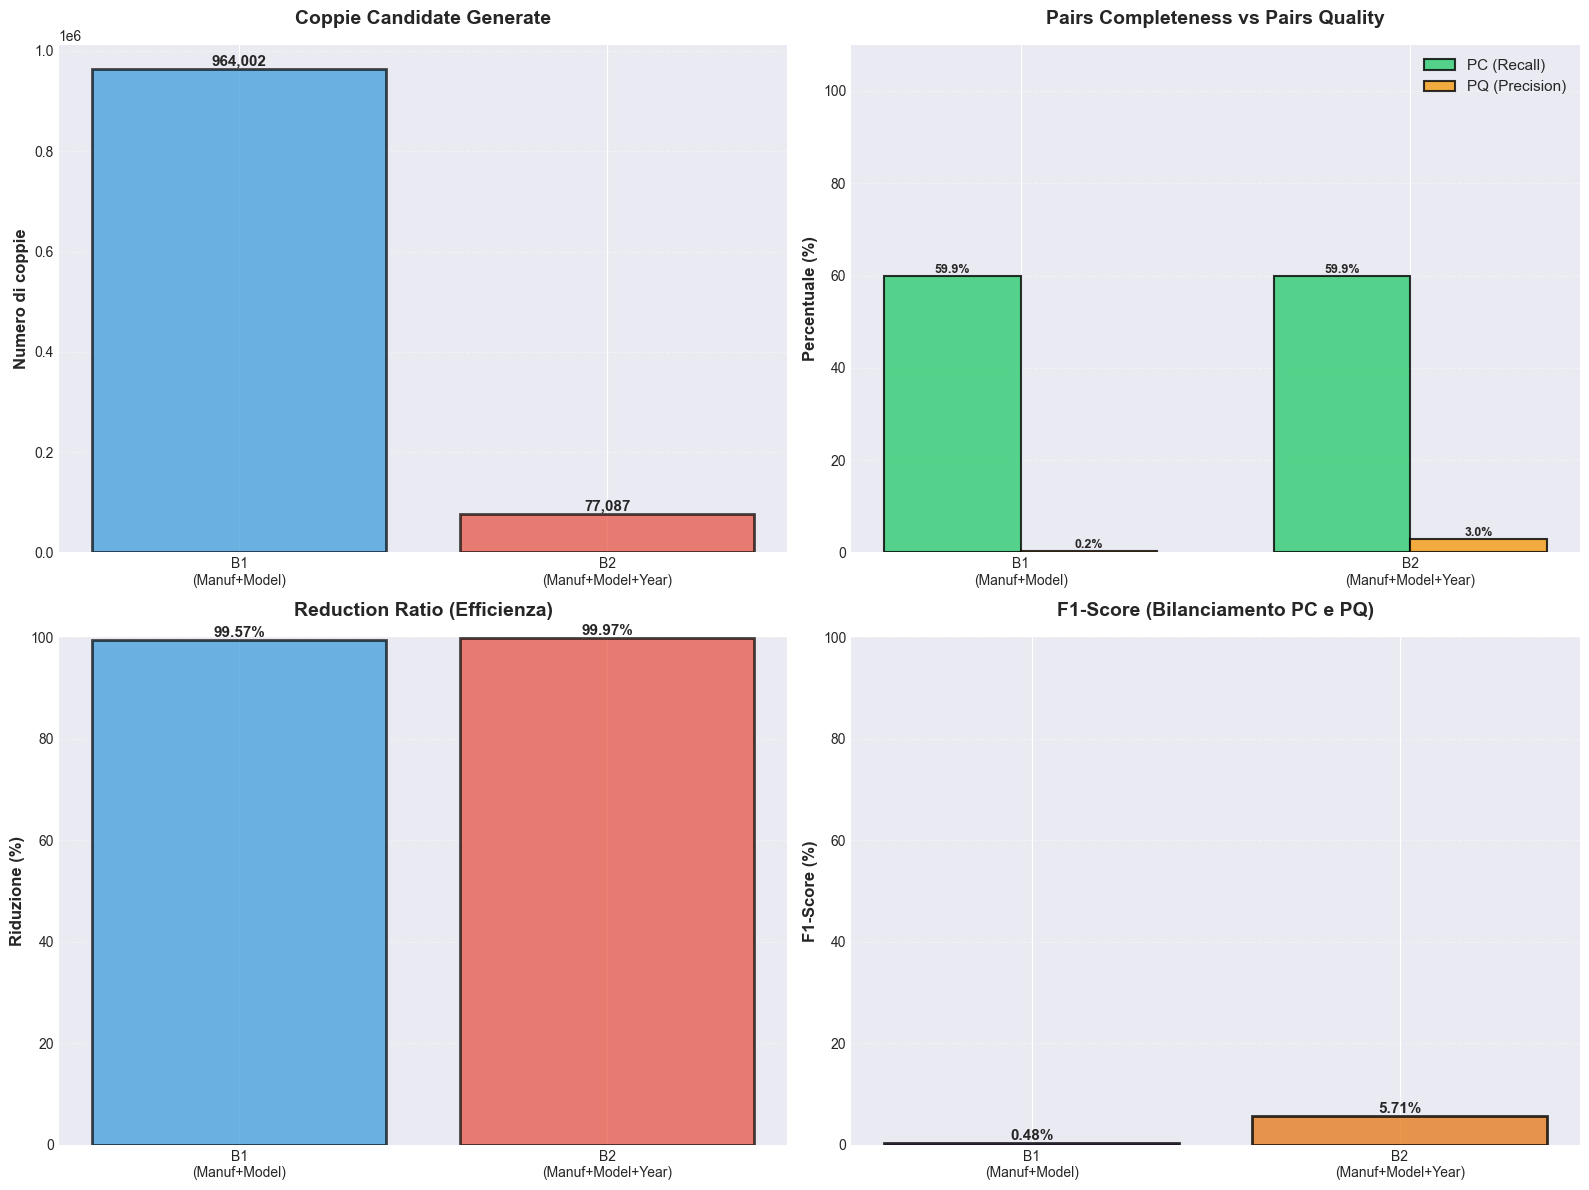

In [29]:
# Visualizzazioni comparative
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

strategies = ['B1\n(Manuf+Model)', 'B2\n(Manuf+Model+Year)']
colors = ['#3498db', '#e74c3c']

# 1. Numero coppie candidate
ax1 = axes[0, 0]
candidates_values = [metrics_B1['total_candidates'], metrics_B2['total_candidates']]
bars1 = ax1.bar(strategies, candidates_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Numero di coppie', fontsize=12, fontweight='bold')
ax1.set_title('Coppie Candidate Generate', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Aggiungi valori
for bar, val in zip(bars1, candidates_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Pairs Completeness e Pairs Quality
ax2 = axes[0, 1]
x = np.arange(len(strategies))
width = 0.35

pc_values = [metrics_B1['pairs_completeness'], metrics_B2['pairs_completeness']]
pq_values = [metrics_B1['pairs_quality'], metrics_B2['pairs_quality']]

bars2a = ax2.bar(x - width/2, pc_values, width, label='PC (Recall)', color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2b = ax2.bar(x + width/2, pq_values, width, label='PQ (Precision)', color='#f39c12', alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Percentuale (%)', fontsize=12, fontweight='bold')
ax2.set_title('Pairs Completeness vs Pairs Quality', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(strategies)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 110)

# Aggiungi valori
for bars in [bars2a, bars2b]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Reduction Ratio
ax3 = axes[1, 0]
rr_values = [metrics_B1['reduction_ratio'], metrics_B2['reduction_ratio']]
bars3 = ax3.bar(strategies, rr_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Riduzione (%)', fontsize=12, fontweight='bold')
ax3.set_title('Reduction Ratio (Efficienza)', fontsize=14, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.set_ylim(0, 100)

# Aggiungi valori
for bar, val in zip(bars3, rr_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. F1-Score
ax4 = axes[1, 1]
f1_values = [metrics_B1['f1_score'], metrics_B2['f1_score']]
bars4 = ax4.bar(strategies, f1_values, color=['#9b59b6', '#e67e22'], alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_ylabel('F1-Score (%)', fontsize=12, fontweight='bold')
ax4.set_title('F1-Score (Bilanciamento PC e PQ)', fontsize=14, fontweight='bold', pad=15)
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_ylim(0, 100)

# Aggiungi valori
for bar, val in zip(bars4, f1_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

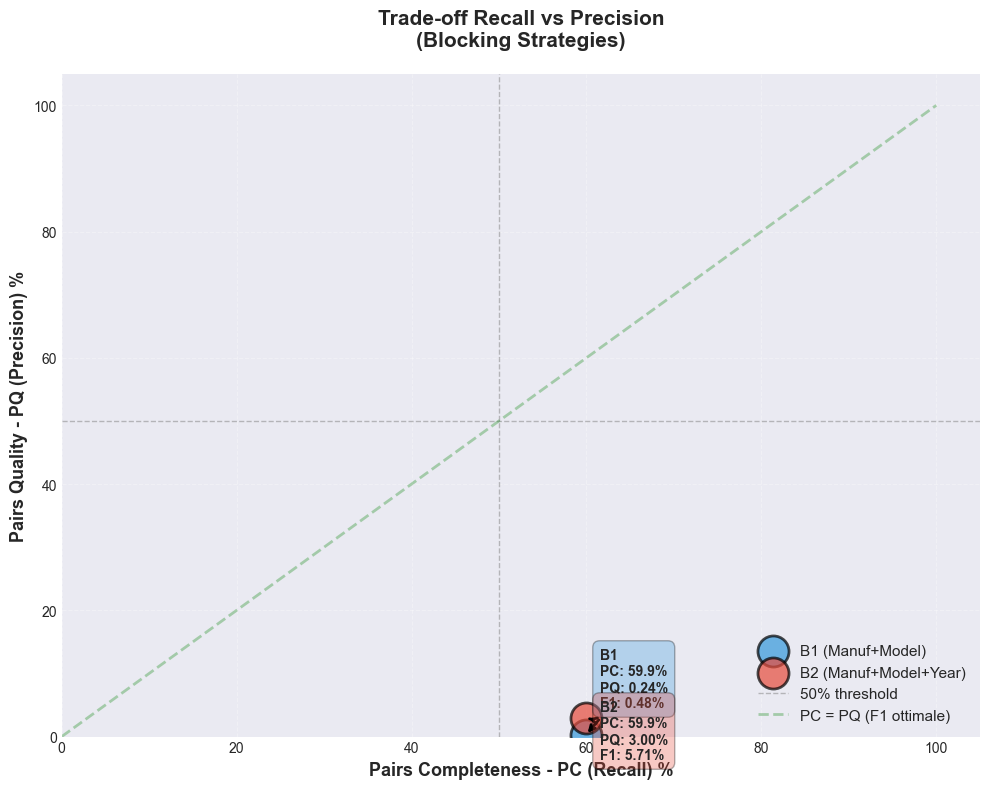

In [30]:
# Grafico trade-off Recall vs Precision
fig, ax = plt.subplots(figsize=(10, 8))

# Plot punti
ax.scatter(
    [metrics_B1['pairs_completeness']], 
    [metrics_B1['pairs_quality']], 
    s=500, 
    c='#3498db', 
    alpha=0.7, 
    edgecolors='black', 
    linewidth=2,
    label='B1 (Manuf+Model)',
    zorder=3
)

ax.scatter(
    [metrics_B2['pairs_completeness']], 
    [metrics_B2['pairs_quality']], 
    s=500, 
    c='#e74c3c', 
    alpha=0.7, 
    edgecolors='black', 
    linewidth=2,
    label='B2 (Manuf+Model+Year)',
    zorder=3
)

# Annotazioni
ax.annotate(
    f"B1\nPC: {metrics_B1['pairs_completeness']:.1f}%\nPQ: {metrics_B1['pairs_quality']:.2f}%\nF1: {metrics_B1['f1_score']:.2f}%",
    xy=(metrics_B1['pairs_completeness'], metrics_B1['pairs_quality']),
    xytext=(10, 20),
    textcoords='offset points',
    fontsize=10,
    fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='#3498db', alpha=0.3, edgecolor='black'),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', linewidth=2)
)

ax.annotate(
    f"B2\nPC: {metrics_B2['pairs_completeness']:.1f}%\nPQ: {metrics_B2['pairs_quality']:.2f}%\nF1: {metrics_B2['f1_score']:.2f}%",
    xy=(metrics_B2['pairs_completeness'], metrics_B2['pairs_quality']),
    xytext=(10, -30),
    textcoords='offset points',
    fontsize=10,
    fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='#e74c3c', alpha=0.3, edgecolor='black'),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', linewidth=2)
)

# Linee di riferimento
ax.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')
ax.axvline(x=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Diagonale F1 ottimale
ax.plot([0, 100], [0, 100], 'g--', linewidth=2, alpha=0.3, label='PC = PQ (F1 ottimale)')

ax.set_xlabel('Pairs Completeness - PC (Recall) %', fontsize=13, fontweight='bold')
ax.set_ylabel('Pairs Quality - PQ (Precision) %', fontsize=13, fontweight='bold')
ax.set_title('Trade-off Recall vs Precision\n(Blocking Strategies)', fontsize=15, fontweight='bold', pad=20)
ax.set_xlim(0, 105)
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

## 8. Analisi Dettagliata Blocchi

In [31]:
# Analisi distribuzione dimensione blocchi
print("ANALISI DISTRIBUZIONE DIMENSIONE BLOCCHI")
print("="*100)

# Calcola dimensione blocchi per B1 e B2
def calculate_block_sizes(df_A, df_B, blocking_key_col):
    """
    Calcola la distribuzione delle dimensioni dei blocchi.
    """
    blocks_A = df_A[blocking_key_col].value_counts()
    blocks_B = df_B[blocking_key_col].value_counts()
    
    # Trova blocchi comuni e calcola prodotto cartesiano per blocco
    common_keys = set(blocks_A.index).intersection(set(blocks_B.index))
    
    block_sizes = []
    for key in common_keys:
        size_A = blocks_A[key]
        size_B = blocks_B[key]
        block_size = size_A * size_B  # Prodotto cartesiano nel blocco
        block_sizes.append({
            'blocking_key': key,
            'size_A': size_A,
            'size_B': size_B,
            'comparisons': block_size
        })
    
    return pd.DataFrame(block_sizes)

df_block_sizes_B1 = calculate_block_sizes(df_A, df_B, 'blocking_key_B1')
df_block_sizes_B2 = calculate_block_sizes(df_A, df_B, 'blocking_key_B2')

print("\n🔹 B1 (Manufacturer + Model)")
print("-"*100)
print(f"Statistiche dimensione blocchi (confronti per blocco):")
print(f"  Media: {df_block_sizes_B1['comparisons'].mean():.1f}")
print(f"  Mediana: {df_block_sizes_B1['comparisons'].median():.1f}")
print(f"  Max: {df_block_sizes_B1['comparisons'].max():,}")
print(f"  Min: {df_block_sizes_B1['comparisons'].min():,}")
print(f"\nTop 10 blocchi più grandi:")
top_blocks_B1 = df_block_sizes_B1.nlargest(10, 'comparisons')
for _, row in top_blocks_B1.iterrows():
    print(f"  {row['blocking_key'][:60]:60s} → {row['comparisons']:,} confronti (A:{row['size_A']}, B:{row['size_B']})")

print("\n🔹 B2 (Manufacturer + Model + Year)")
print("-"*100)
print(f"Statistiche dimensione blocchi (confronti per blocco):")
print(f"  Media: {df_block_sizes_B2['comparisons'].mean():.1f}")
print(f"  Mediana: {df_block_sizes_B2['comparisons'].median():.1f}")
print(f"  Max: {df_block_sizes_B2['comparisons'].max():,}")
print(f"  Min: {df_block_sizes_B2['comparisons'].min():,}")
print(f"\nTop 10 blocchi più grandi:")
top_blocks_B2 = df_block_sizes_B2.nlargest(10, 'comparisons')
for _, row in top_blocks_B2.iterrows():
    print(f"  {row['blocking_key'][:60]:60s} → {row['comparisons']:,} confronti (A:{row['size_A']}, B:{row['size_B']})")

ANALISI DISTRIBUZIONE DIMENSIONE BLOCCHI

🔹 B1 (Manufacturer + Model)
----------------------------------------------------------------------------------------------------
Statistiche dimensione blocchi (confronti per blocco):
  Media: 1983.5
  Mediana: 35.5
  Max: 187,568
  Min: 1

Top 10 blocchi più grandi:
  ford||f-150                                                  → 187,568 confronti (A:304, B:617)
  chevrolet||silverado 1500                                    → 65,800 confronti (A:175, B:376)
  ram||1500                                                    → 49,434 confronti (A:154, B:321)
  ford||escape                                                 → 43,035 confronti (A:151, B:285)
  toyota||camry                                                → 30,140 confronti (A:137, B:220)
  nissan||altima                                               → 26,125 confronti (A:125, B:209)
  ford||fusion                                                 → 24,745 confronti (A:101, B:245)
  chevrole

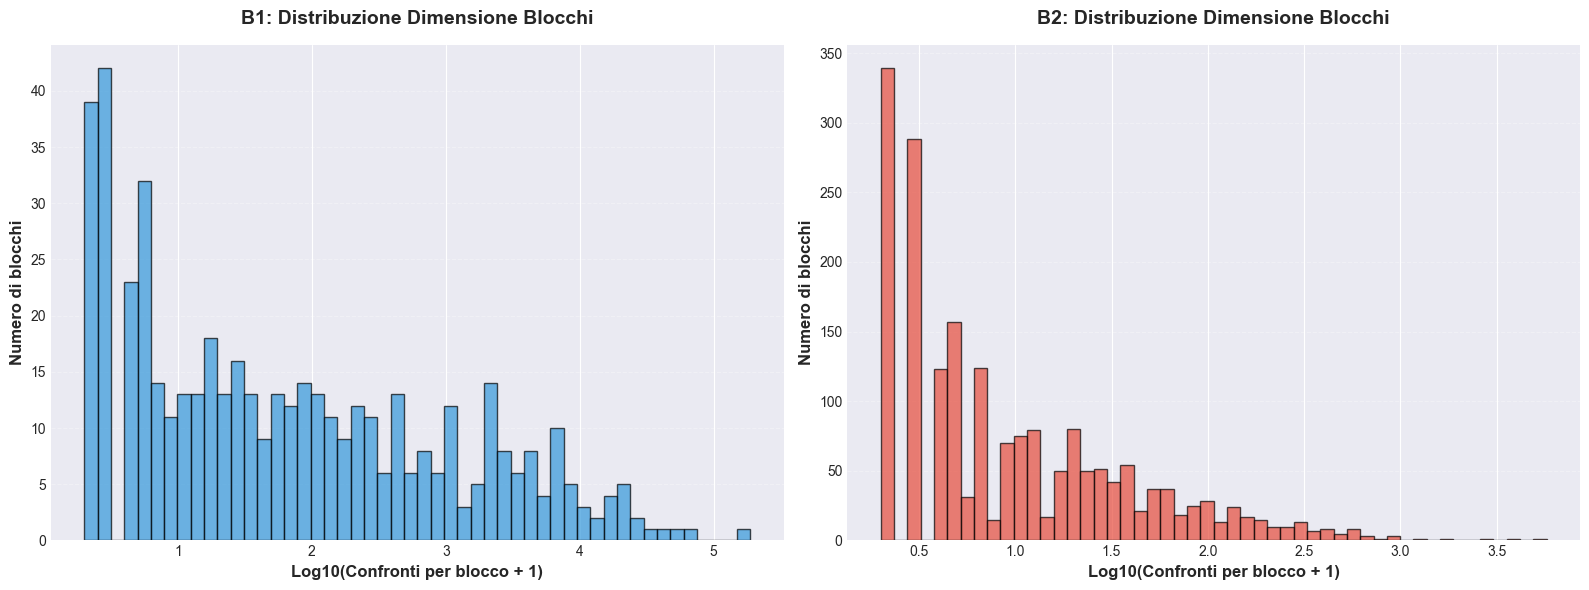

In [32]:
# Visualizza distribuzione dimensione blocchi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# B1 - Histogram
# Usa scala log per gestire outlier
comparisons_B1 = df_block_sizes_B1['comparisons']
ax1.hist(np.log10(comparisons_B1 + 1), bins=50, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1)
ax1.set_xlabel('Log10(Confronti per blocco + 1)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Numero di blocchi', fontsize=12, fontweight='bold')
ax1.set_title('B1: Distribuzione Dimensione Blocchi', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# B2 - Histogram
comparisons_B2 = df_block_sizes_B2['comparisons']
ax2.hist(np.log10(comparisons_B2 + 1), bins=50, color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1)
ax2.set_xlabel('Log10(Confronti per blocco + 1)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Numero di blocchi', fontsize=12, fontweight='bold')
ax2.set_title('B2: Distribuzione Dimensione Blocchi', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## 9. Salvataggio Risultati

In [33]:
import os

# Crea cartella per risultati blocking
os.makedirs('blocking_results', exist_ok=True)

print("SALVATAGGIO RISULTATI BLOCKING")
print("="*100)

# 1. Salva coppie candidate
print("\n1. Salvataggio coppie candidate...")
df_candidates_B1.to_csv('blocking_results/candidates_B1.csv', index=False)
df_candidates_B2.to_csv('blocking_results/candidates_B2.csv', index=False)
print(f"   ✓ blocking_results/candidates_B1.csv ({len(df_candidates_B1):,} coppie)")
print(f"   ✓ blocking_results/candidates_B2.csv ({len(df_candidates_B2):,} coppie)")

# 2. Salva metriche
print("\n2. Salvataggio metriche...")
metrics_summary = {
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_info': {
        'dataset_A_size': len(df_A),
        'dataset_B_size': len(df_B),
        'cartesian_product': cartesian_product,
        'ground_truth_positives': len(df_gt_positive)
    },
    'B1_manufacturer_model': {
        'blocking_key': 'manufacturer + model',
        'total_candidates': int(metrics_B1['total_candidates']),
        'true_matches_found': int(metrics_B1['true_matches_found']),
        'true_matches_missed': int(metrics_B1['true_matches_missed']),
        'pairs_completeness_pct': float(metrics_B1['pairs_completeness']),
        'pairs_quality_pct': float(metrics_B1['pairs_quality']),
        'reduction_ratio_pct': float(metrics_B1['reduction_ratio']),
        'f1_score_pct': float(metrics_B1['f1_score'])
    },
    'B2_manufacturer_model_year': {
        'blocking_key': 'manufacturer + model + year',
        'total_candidates': int(metrics_B2['total_candidates']),
        'true_matches_found': int(metrics_B2['true_matches_found']),
        'true_matches_missed': int(metrics_B2['true_matches_missed']),
        'pairs_completeness_pct': float(metrics_B2['pairs_completeness']),
        'pairs_quality_pct': float(metrics_B2['pairs_quality']),
        'reduction_ratio_pct': float(metrics_B2['reduction_ratio']),
        'f1_score_pct': float(metrics_B2['f1_score'])
    }
}

with open('blocking_results/blocking_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)
print(f"   ✓ blocking_results/blocking_metrics.json")

# 3. Genera report testuale
print("\n3. Generazione report testuale...")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_file = f'blocking_results/blocking_report_{timestamp}.txt'

with open(report_file, 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("BLOCKING STRATEGIES EVALUATION REPORT\n")
    f.write(f"Generato il: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*100 + "\n\n")
    
    f.write("1. DATI SORGENTE\n")
    f.write("-"*100 + "\n")
    f.write(f"Dataset A (Craigslist): {len(df_A):,} record\n")
    f.write(f"Dataset B (Used Cars): {len(df_B):,} record\n")
    f.write(f"Prodotto cartesiano: {cartesian_product:,} confronti\n")
    f.write(f"Ground-Truth positives: {len(df_gt_positive):,} coppie\n\n")
    
    f.write("2. STRATEGIA B1: Manufacturer + Model\n")
    f.write("-"*100 + "\n")
    f.write(f"Coppie candidate: {metrics_B1['total_candidates']:,}\n")
    f.write(f"Veri match trovati: {metrics_B1['true_matches_found']:,}\n")
    f.write(f"Veri match persi: {metrics_B1['true_matches_missed']:,}\n")
    f.write(f"Pairs Completeness (PC): {metrics_B1['pairs_completeness']:.2f}%\n")
    f.write(f"Pairs Quality (PQ): {metrics_B1['pairs_quality']:.2f}%\n")
    f.write(f"Reduction Ratio (RR): {metrics_B1['reduction_ratio']:.2f}%\n")
    f.write(f"F1-Score: {metrics_B1['f1_score']:.2f}%\n\n")
    
    f.write("3. STRATEGIA B2: Manufacturer + Model + Year\n")
    f.write("-"*100 + "\n")
    f.write(f"Coppie candidate: {metrics_B2['total_candidates']:,}\n")
    f.write(f"Veri match trovati: {metrics_B2['true_matches_found']:,}\n")
    f.write(f"Veri match persi: {metrics_B2['true_matches_missed']:,}\n")
    f.write(f"Pairs Completeness (PC): {metrics_B2['pairs_completeness']:.2f}%\n")
    f.write(f"Pairs Quality (PQ): {metrics_B2['pairs_quality']:.2f}%\n")
    f.write(f"Reduction Ratio (RR): {metrics_B2['reduction_ratio']:.2f}%\n")
    f.write(f"F1-Score: {metrics_B2['f1_score']:.2f}%\n\n")
    
    f.write("4. CONFRONTO E RACCOMANDAZIONI\n")
    f.write("-"*100 + "\n")
    
    if metrics_B1['f1_score'] > metrics_B2['f1_score']:
        f.write("✅ RACCOMANDAZIONE: B1 (Manufacturer + Model)\n")
        f.write("   F1-Score superiore indica miglior bilanciamento recall/precision\n")
        f.write(f"   Cattura più veri match ({metrics_B1['pairs_completeness']:.1f}% vs {metrics_B2['pairs_completeness']:.1f}%)\n")
    else:
        f.write("✅ RACCOMANDAZIONE: B2 (Manufacturer + Model + Year)\n")
        f.write("   F1-Score superiore indica miglior bilanciamento recall/precision\n")
        f.write(f"   Maggiore efficienza computazionale ({metrics_B2['reduction_ratio']:.1f}% vs {metrics_B1['reduction_ratio']:.1f}%)\n")
    
    f.write("\nConsiderazioni:\n")
    f.write("  - B1 è più permissivo: maggiore recall, cattura più match\n")
    f.write("  - B2 è più efficiente: meno confronti, blocchi più piccoli\n")
    f.write("  - Scelta dipende da priorità: recall vs efficienza\n")

print(f"   ✓ {report_file}")

print("\n" + "="*100)
print("✅ COMPLETATO!")
print("="*100)
print("\nFile generati:")
print("  📁 blocking_results/candidates_B1.csv - Coppie candidate B1")
print("  📁 blocking_results/candidates_B2.csv - Coppie candidate B2")
print("  📁 blocking_results/blocking_metrics.json - Metriche complete")
print(f"  📁 {report_file}")

SALVATAGGIO RISULTATI BLOCKING

1. Salvataggio coppie candidate...
   ✓ blocking_results/candidates_B1.csv (964,002 coppie)
   ✓ blocking_results/candidates_B2.csv (77,087 coppie)

2. Salvataggio metriche...
   ✓ blocking_results/blocking_metrics.json

3. Generazione report testuale...
   ✓ blocking_results/blocking_report_20260202_145631.txt

✅ COMPLETATO!

File generati:
  📁 blocking_results/candidates_B1.csv - Coppie candidate B1
  📁 blocking_results/candidates_B2.csv - Coppie candidate B2
  📁 blocking_results/blocking_metrics.json - Metriche complete
  📁 blocking_results/blocking_report_20260202_145631.txt


## 10. Conclusioni

### Risultati Ottenuti

Abbiamo implementato e valutato due strategie di blocking:

**B1 (Manufacturer + Model)**:
- ✅ Pro: Alta recall (cattura più veri match)
- ✅ Pro: Robusto a errori nell'anno
- ⚠️ Contro: Più coppie candidate da processare

**B2 (Manufacturer + Model + Year)**:
- ✅ Pro: Maggiore efficienza (blocchi più piccoli)
- ✅ Pro: Migliore precision (meno falsi positivi)
- ⚠️ Contro: Può perdere match con errori nell'anno

### Trade-off Fondamentali

1. **Recall vs Precision**:
   - Blocking più permissivo (B1) → alta recall, bassa precision
   - Blocking più restrittivo (B2) → bassa recall, alta precision

2. **Completezza vs Efficienza**:
   - Meno attributi → più match catturati ma più confronti
   - Più attributi → meno confronti ma rischio di perdere match

### Prossimi Passi

1. **Matching**: Applicare algoritmi di similarity sulle coppie candidate
2. **Classificazione**: Trainare modelli ML per classificare match/non-match
3. **Ottimizzazione**: Considerare blocking ibridi o multi-pass
4. **Valutazione**: Confrontare con approcci alternativi (LSH, Canopy, etc.)

### Metriche Chiave da Ricordare

- **Pairs Completeness (PC)**: % di veri match catturati
- **Pairs Quality (PQ)**: % di coppie candidate che sono veri match
- **Reduction Ratio (RR)**: % di confronti evitati
- **F1-Score**: Bilanciamento tra PC e PQ